# Has the use of statistics produced a measurable result of run production in Major League Baseball, or are the latest numbers simply a normal progression of the game as time goes on?!
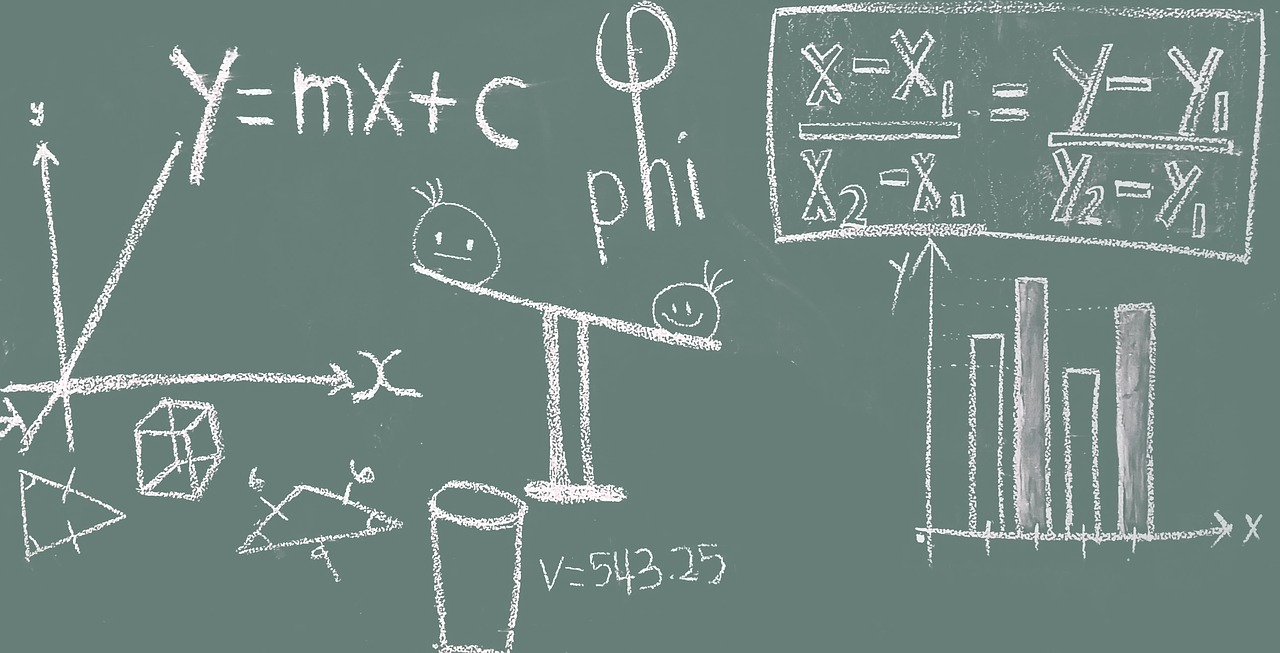

#### This is what we will dig through in the following slides. These slides will include means from three generations of the modern game: The lowered mound era, The steroid era, and The sabermetrics era.

#### In 1968, MLB made the last change they have made to the mound, the point from which the pitcher throws the ball. This change overturned a trend where pitching dominated batting, and the after effects of the lower mound were immdiately felt through increased offensive numbers, namely runs produced.
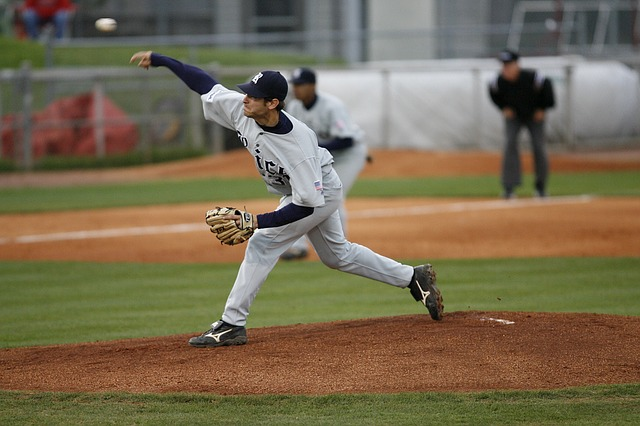

#### In 1991, Baseball adopted it's first anti-doping policy. It was never enforced and did not match watchdog lists, such as WADA, who oversees the Olympics. The period from 1991 until 2005 is widely known to baseball enthusiasts as the Steroid Era.
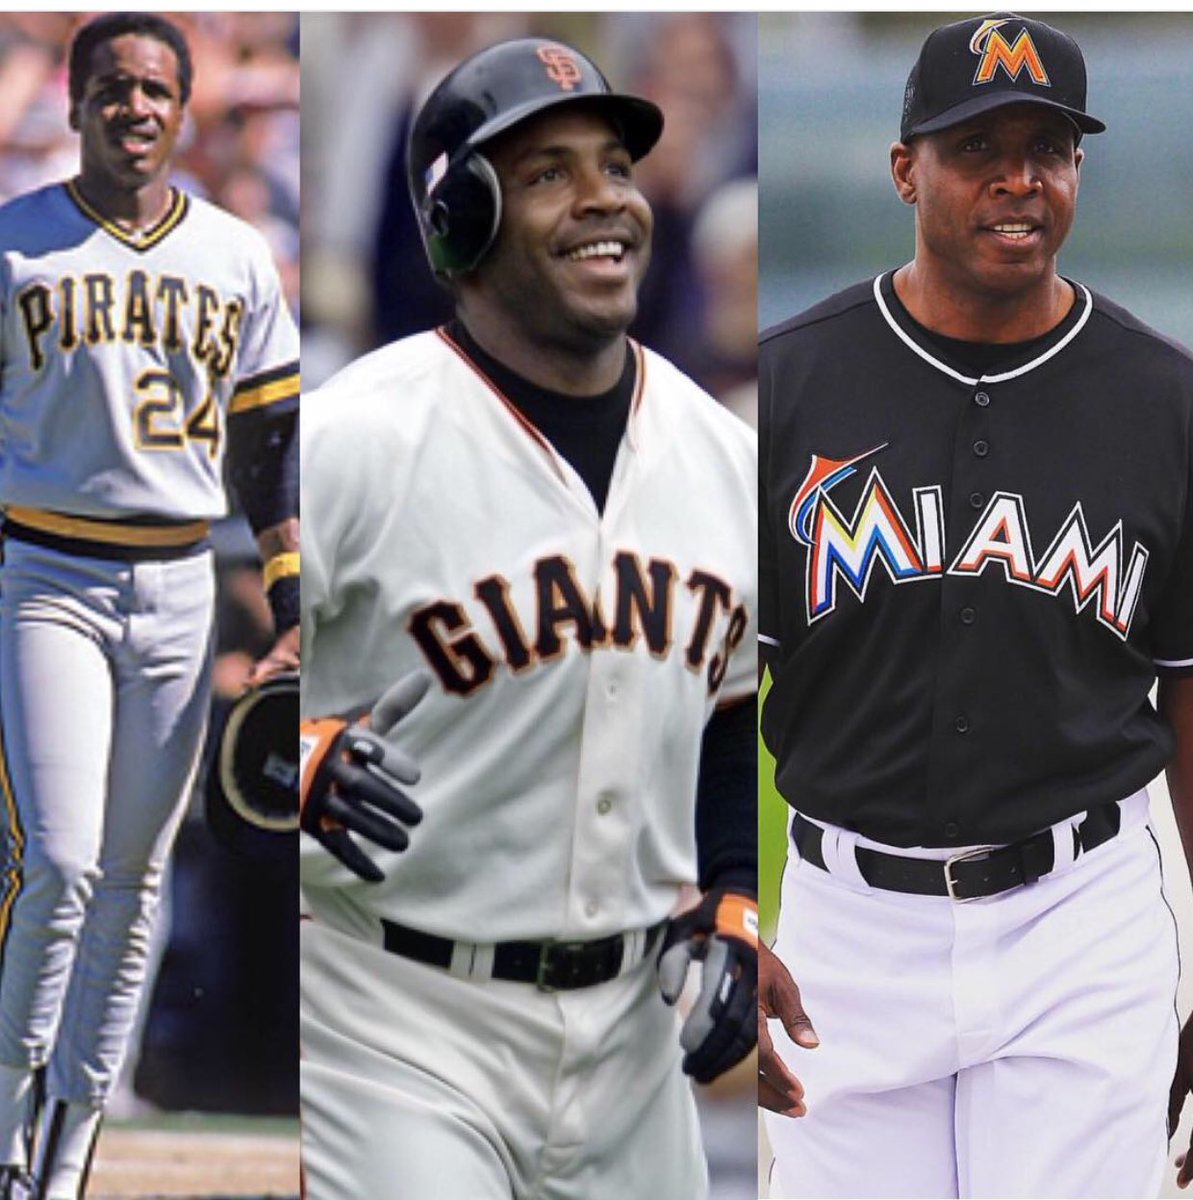

#### In 2003, the book Moneyball was released, ushering in the stats age called Sabermetrics. A high focus was placed on non-traditional stats as better indicators of run production. Whereas players were previosly measure on the statistics of batting average, home runs, and RBI, now th focus is on on base percentage, slugging percentage, and a new stat called on base plus slugging.
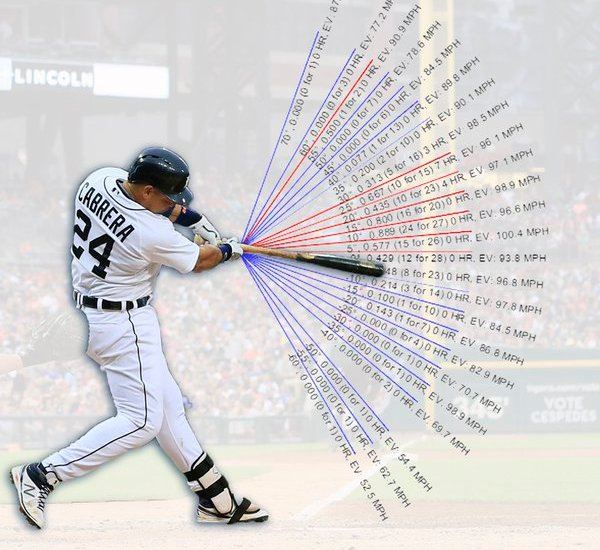

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

url = 'https://raw.githubusercontent.com/danielmoore19/baseball/master/baseballdatabank-2019.2/core/Batting.csv'
data = pd.read_csv(url)
batdata = data[(data['AB'] >= 1)] # To remove batters with no recorded At Bats
batdata = batdata.dropna()
batdata.head()
# This is included in order to see the different columns we are working with. Relevant columns are:
# AB stands for times a batter officially bats (not to be confused with the plate appearance 'PA' variable we will create)
# R which stands for runs scored by a batter
# H is hits, which includes all hits: single, 2B, 3B, HR (registers an AB and a PA)
# 2B are doubles, 3B are triple, and HR are homers (registers an AB and a PA)
# BB which is a walk, a free base due to poor pitch location (does not register an AB, but does a PA)
# IBB which is an intentional BB, a free base due to the pitcher favoring a matchup with the next batter
# (IBB is a separate stat, but is also included in BB, so we do not count it twice)
# HBP which is counts like a BB, but it due to the picher hitting the batter (does not register an AB, but does a PA)
# SF, a sacrifice fly, a non-hit which creates an R and does not count against a batter's BA
# (SF does not register an AB, but it does register a PA)

playerID  yearID  stint teamID lgID    G   AB    R    H  2B  3B  HR    RBI   SB   CS  BB    SO  IBB  HBP   SH   SF  GIDP
37464  aaronha01    1955      1    ML1   NL  153  602  105  189  37   9  27  106.0  3.0  1.0  49  61.0  5.0  3.0  7.0  4.0  20.0
37465   aberal01    1955      1    DET   AL   39   17    0    1   0   0   0    0.0  0.0  0.0   0   9.0  0.0  0.0  2.0  0.0   1.0
37466  abernte02    1955      1    WS1   AL   40   26    1    4   0   0   0    0.0  0.0  0.0   0   6.0  0.0  0.0  4.0  0.0   1.0
37467  abramca01    1955      1    BAL   AL  118  309   56   75  12   3   6   32.0  2.0  8.0  89  69.0  2.0  3.0  3.0  3.0   6.0
37468  adamsbo03    1955      1    CIN   NL   64  150   23   41  11   2   2   20.0  2.0  0.0  20  21.0  1.0  3.0  2.0  1.0   3.0

***PA is a variable to help determine number of plate appearances (PA) the batter has made. This is required to calculate two things: does a batter "qualify" for end of year statistical awards, and to determine a batter's
On Base Percentage (OBP), which is part of the stat On Base Plus Slugging (OPS).***

***All formulas may be found at http://www.baseballscorecard.com/statistics.htm***

***All print statements prior to plots are simply to ensure forumlas and variables are bing calculated correctly***

***Some vocabulary and abbreviations to help out with the presentation:
***AB stands for times a batter officially bats (not to be confused with the plate appearance 'PA' variable we will create)
***R which stands for runs scored by a batter
***H is hits, which includes all hits: single (counts as 1 base), 2B, 3B, HR
***2B are doubles (counts as two bases), 3B are triples (three bases), and HR are homers (four bases)
***BB which is a walk, a free base due to poor pitch location (does not register an AB, but does a PA)
***IBB which is an intentional BB, a free base due to the pitcher favoring a matchup with the next batter
***HBP which counts like a BB, but is due to the picher hitting the batter (does not register an AB, but does a PA)
***SF, a sacrifice fly, a non-hit which creates an R and does not count against a batter's BA
***(SF does not register an AB, but it does register a PA)
***TB is total bases, and is the number value of each base a batter acquires via registering H

***And lastly, some statistics we will encounter:
***OPS means On base Plus Slugging, and is a combination of two stats called on base percentage and slugging percentage
***OBP is On Base Percentage
***SLUG as mentiond earlier is the slugging percentage
***BA, which is the batter's average for registering H

In [29]:
batdata['PA'] = batdata['AB']+batdata['BB']+batdata['HBP']+batdata['SF']
print(batdata['PA'])

37464     658.0
37465      17.0
37466      26.0
37467     404.0
37468     174.0
          ...  
105856    114.0
105857      2.0
105858    323.0
105859    519.0
105860    405.0
Name: PA, Length: 53230, dtype: float64


***OnBase is a variable used to determine the OBP of a batter. A batter's OBP measures how often the batter gets on base given their PA. Higher is better, max is 1.000.***

In [30]:
batdata['OnBase'] = (batdata['H']+batdata['BB']+batdata['HBP'])
batdata['OBP'] = batdata['OnBase']/batdata['PA']
batdata['OBP'] = batdata['OBP'].round(3)
print(batdata['OBP'])

37464     0.366
37465     0.059
37466     0.154
37467     0.413
37468     0.368
          ...  
105856    0.281
105857    0.000
105858    0.337
105859    0.378
105860    0.259
Name: OBP, Length: 53230, dtype: float64


***The next several cells will be used to determine a batter's slugging percentage (SLUG). SLUG is part of the statistic OPS. It is hypothesized that the higher a batter's OPS, the more runs (R) they create. The total of these cells will yield the batter's total bases acquired (TB). A single is worth (1) base, a double worth (2), a triple (3), and a homer (4).***

In [31]:
batdata['single'] = batdata['H']-(batdata['HR']+batdata['2B']+batdata['3B'])
print(batdata['single'])

37464     116
37465       1
37466       4
37467      54
37468      26
         ... 
105856     17
105857      0
105858     40
105859     99
105860     37
Name: single, Length: 53230, dtype: int64


In [32]:
batdata['double'] = batdata['2B'].apply(lambda x: x*2)
print(batdata['double'])

37464     74
37465      0
37466      0
37467     24
37468     22
          ..
105856    10
105857     0
105858    42
105859    56
105860    36
Name: double, Length: 53230, dtype: int64


In [33]:
batdata['triple'] = batdata['3B'].apply(lambda x: x*3)
print(batdata['triple'])

37464     27
37465      0
37466      0
37467      9
37468      6
          ..
105856     0
105857     0
105858     6
105859     9
105860     0
Name: triple, Length: 53230, dtype: int64


In [34]:
batdata['homer'] = batdata['HR'].apply(lambda x: x*4)
print(batdata['homer'])

37464     108
37465       0
37466       0
37467      24
37468       8
         ... 
105856      8
105857      0
105858     52
105859     36
105860     80
Name: homer, Length: 53230, dtype: int64


In [35]:
batdata['TB'] = batdata['single']+batdata['double']+batdata['triple']+batdata['homer']
print(batdata['TB'])

37464     325
37465       1
37466       4
37467     111
37468      62
         ... 
105856     35
105857      0
105858    140
105859    200
105860    153
Name: TB, Length: 53230, dtype: int64


***We can now determine a batter's SLUG. Higher is better, max is 4.000 (and completely unrealistic).***

In [36]:
batdata['SLUG'] = batdata['TB']/batdata['AB']
batdata['SLUG'] = batdata['SLUG'].round(3)
print(batdata['SLUG'])

37464     0.540
37465     0.059
37466     0.154
37467     0.359
37468     0.413
          ...  
105856    0.330
105857    0.000
105858    0.486
105859    0.440
105860    0.410
Name: SLUG, Length: 53230, dtype: float64


***Now that we have our OBP and our SLUG, we can calculate for OPS. Higher is better, max is 5.000.***

In [37]:
# formula to determine a batter's on base plus slugging percentage
batdata['OPS'] = batdata['OBP']+batdata['SLUG']
print(batdata['OPS'])

37464     0.906
37465     0.118
37466     0.308
37467     0.772
37468     0.781
          ...  
105856    0.611
105857    0.000
105858    0.823
105859    0.818
105860    0.669
Name: OPS, Length: 53230, dtype: float64


***The formula for calculating a batter's batting average (BA), which measures how often they get on base via a successful hit attempt (single, double, triple, or homer). I decided to include this for further testing of correlation for production of R since R is primarily produced by a hit (a BB, or a walk, can also generate R, but is more rare--however a BB still counts for OBP and that is why OBP is part of the OPS equation and not BA).***

In [38]:
# forumla to determine a batter's hitting average
batdata['BA'] = batdata['H']/batdata['AB']

***These variables form the first set of data pools for our tests. In 1968, after a year in which pitchers dominated batters, Major League Baseball (MLB) decided to lower the height of the pitcher's mound (where the pitcher throws the ball) to increase R production. This is represented by the data set lowerMound.***

***In the 1990s, MLB responded to calls for drug testing of players to determine the presence of Performance Enhancing Drugs (PEDs). Even though certain PEDs were shown on the list, testing was sparse and the list did not match the World Anti-Doping Agency's (WADA) list, the agency which tested the most sports organizations, including the Olympics. This data set is labeled steroidEra.***

***In 2003, the book Moneyball is released detailing how a team, The Oakland Athletics, competed with a significantly smaller payroll than other teams (less than 50mil against teams with greater than 100mil). It also began the serious inquiry into PEDs which would culiminate in 2005 with increased player suspensions and the release of the book Juiced by former player Jose Canseco.  This data set is labeled statsEra.***

In [39]:
lowerMound = batdata[(batdata['yearID'] >= 1968) & (batdata['yearID'] <= 1991) & (batdata['PA'] >= 502)]
lowerMound.describe()


yearID        stint            G           AB            R            H           2B           3B           HR          RBI           SB           CS           BB           SO          IBB          HBP           SH           SF         GIDP           PA       OnBase          OBP       single       double       triple        homer           TB         SLUG          OPS           BA
count  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000  2760.000000
mean   1979.824638     1.005797   147.243478   541.988406    74.918841   149.353261    25.286957     4.080435    15.155435    69.844928    13.770652     6.243478    55.454710    76.294928     6.164855     3.250362     3.806884     4.854348    11.926812   605.547826   208.058333     0.342729   104.830435    50.573913    12.241304    60.621739   228.267391     0.420439     0.763169     0.274759
std       6.871658     0.075931     9.902577    56.900693    17.827816    24.355502     7.344935     3.067924    10.183569    22.927922    15.805379     5.013949    22.230907    29.205276     5.031614     3.081942     4.493807     2.640297     5.069263    60.087732    33.081016     0.034787    21.413012    14.689870     9.203772    40.734277    46.231859     0.068504     0.093514     0.026892
min    1968.000000     1.000000   111.000000   396.000000    25.000000    80.000000     6.000000     0.000000     0.000000    12.000000     0.000000     0.000000    11.000000    13.000000     0.000000     0.000000     0.000000     0.000000     0.000000   502.000000   112.000000     0.222000    39.000000    12.000000     0.000000     0.000000   115.000000     0.239000     0.461000     0.178571
25%    1974.000000     1.000000   141.000000   497.000000    62.000000   132.000000    20.000000     2.000000     7.000000    52.000000     3.000000     3.000000    39.000000    55.000000     2.000000     1.000000     1.000000     3.000000     8.000000   555.000000   184.000000     0.319000    90.000000    40.000000     6.000000    28.000000   194.000000     0.371000     0.698000     0.255848
50%    1979.000000     1.000000   149.000000   542.000000    74.000000   148.000000    25.000000     3.000000    14.000000    68.000000     8.000000     5.000000    52.500000    73.000000     5.000000     3.000000     2.000000     4.000000    11.000000   607.000000   205.000000     0.342000   103.000000    50.000000     9.000000    56.000000   225.000000     0.419000     0.762000     0.273985
75%    1986.000000     1.000000   155.000000   584.000000    86.250000   165.000000    30.000000     6.000000    22.000000    86.000000    19.000000     9.000000    69.000000    93.000000     9.000000     4.000000     6.000000     6.000000    15.000000   653.000000   230.000000     0.366000   118.000000    60.000000    18.000000    88.000000   259.000000     0.465000     0.824000     0.292179
max    1991.000000     2.000000   163.000000   705.000000   146.000000   240.000000    54.000000    21.000000    52.000000   149.000000   130.000000    42.000000   148.000000   189.000000    45.000000    50.000000    40.000000    18.000000    36.000000   769.000000   342.000000     0.476000   187.000000   108.000000    63.000000   208.000000   406.000000     0.669000     1.118000     0.389755

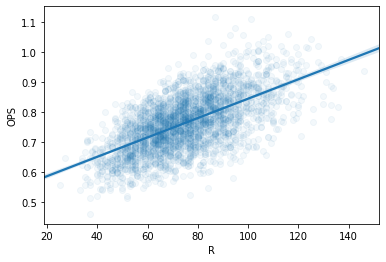

In [40]:
sns.regplot(x='R', y='OPS', data=lowerMound, scatter_kws={'alpha':0.05})
plt.show()

In [41]:
steroidEra = batdata[(batdata['yearID'] >= 1991) & (batdata['yearID'] <= 2005) & (batdata['PA'] >= 502)]
steroidEra.describe()


yearID        stint            G           AB            R            H           2B           3B           HR          RBI           SB           CS           BB           SO          IBB          HBP           SH           SF         GIDP           PA       OnBase          OBP       single       double       triple        homer           TB         SLUG          OPS           BA
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000
mean   1998.567946     1.000519   146.213693   542.622925    84.008817   154.029564    30.147303     3.314834    19.884336    79.957988    12.589212     5.154046    59.251556    90.303423     5.509855     5.345954     2.607365     5.136929    12.257780   612.357365   218.627075     0.355899   100.683091    60.294606     9.944502    79.537344   250.459544     0.460829     0.816729     0.283275
std       4.270018     0.022774    10.907260    57.459658    19.452133    24.104849     7.989295     2.804279    11.715606    25.892192    13.299017     4.310909    24.661623    30.025897     6.211704     4.453662     3.825581     2.704995     4.951392    63.374853    37.119737     0.038452    20.758869    15.978590     8.412838    46.862424    51.723843     0.078353     0.107967     0.027115
min    1991.000000     1.000000   110.000000   373.000000    33.000000    80.000000    11.000000     0.000000     0.000000    17.000000     0.000000     0.000000    10.000000    14.000000     0.000000     0.000000     0.000000     0.000000     0.000000   502.000000   135.000000     0.259000    39.000000    22.000000     0.000000     0.000000   131.000000     0.291000     0.563000     0.178571
25%    1995.000000     1.000000   139.000000   495.000000    69.000000   136.000000    25.000000     1.000000    11.000000    60.000000     3.000000     2.000000    42.000000    69.000000     2.000000     2.000000     0.000000     3.000000     9.000000   558.000000   190.000000     0.329000    86.000000    50.000000     3.000000    44.000000   212.000000     0.403000     0.739000     0.264163
50%    1999.000000     1.000000   148.000000   542.000000    83.000000   153.000000    30.000000     3.000000    18.500000    78.000000     8.000000     4.000000    56.000000    88.000000     4.000000     4.000000     1.000000     5.000000    12.000000   615.000000   216.000000     0.353000    99.000000    60.000000     9.000000    74.000000   246.000000     0.454500     0.805000     0.281727
75%    2002.000000     1.000000   155.000000   586.000000    97.000000   170.000000    35.000000     5.000000    27.000000   100.000000    18.000000     7.000000    73.000000   109.250000     7.000000     7.000000     4.000000     7.000000    15.000000   666.000000   244.000000     0.379000   113.000000    70.000000    15.000000   108.000000   286.250000     0.509250     0.880000     0.301170
max    2005.000000     2.000000   163.000000   704.000000   152.000000   262.000000    59.000000    21.000000    73.000000   165.000000    78.000000    28.000000   232.000000   195.000000   120.000000    34.000000    30.000000    17.000000    32.000000   773.000000   376.000000     0.609000   225.000000   118.000000    63.000000   292.000000   425.000000     0.863000     1.421000     0.378995

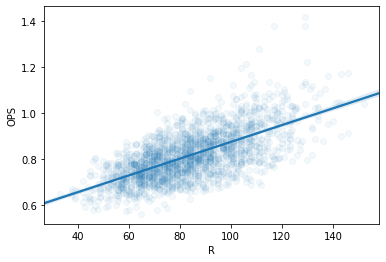

In [42]:
sns.regplot(x='R', y='OPS', data=steroidEra, scatter_kws={'alpha':0.05})
plt.show()

In [43]:
statsEra = batdata[(batdata['yearID'] >= 2003) & (batdata['PA'] >= 502)]
statsEra.describe()


yearID   stint            G           AB            R            H           2B           3B           HR          RBI           SB           CS           BB           SO          IBB          HBP           SH           SF         GIDP           PA       OnBase          OBP       single       double       triple        homer           TB         SLUG          OPS           BA
count  2221.000000  2221.0  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000  2221.000000
mean   2010.335885     1.0   146.580819   545.470059    79.615939   151.263395    30.512832     3.111211    19.776227    76.105808    10.582170     3.754165    55.125619   103.457902     4.806394     5.633949     1.915353     4.597028    12.582620   610.826655   212.022963     0.346100    97.863125    61.025664     9.333633    79.104908   247.327330     0.452772     0.798872     0.276580
std       4.633866     0.0    10.737464    57.062481    17.888410    24.272579     7.923306     2.868714    10.325203    22.390335    11.775303     3.492448    21.936394    33.297048     5.660387     4.281607     3.154725     2.398229     5.471716    62.499904    34.520433     0.034779    21.503848    15.846612     8.606141    41.300811    46.528297     0.067011     0.093637     0.026991
min    2003.000000     1.0   109.000000   373.000000    30.000000    79.000000     9.000000     0.000000     0.000000    17.000000     0.000000     0.000000     9.000000    27.000000     0.000000     0.000000     0.000000     0.000000     0.000000   502.000000   127.000000     0.243000    32.000000    18.000000     0.000000     0.000000   127.000000     0.268000     0.539000     0.168085
25%    2006.000000     1.0   139.000000   501.000000    67.000000   133.000000    25.000000     1.000000    12.000000    59.000000     2.000000     1.000000    40.000000    79.000000     1.000000     3.000000     0.000000     3.000000     9.000000   559.000000   186.000000     0.323000    83.000000    50.000000     3.000000    48.000000   214.000000     0.405000     0.733000     0.258004
50%    2010.000000     1.0   148.000000   547.000000    78.000000   150.000000    30.000000     2.000000    19.000000    75.000000     6.000000     3.000000    52.000000   101.000000     3.000000     5.000000     0.000000     4.000000    12.000000   613.000000   211.000000     0.345000    97.000000    60.000000     6.000000    76.000000   243.000000     0.449000     0.791000     0.276342
75%    2014.000000     1.0   156.000000   589.000000    91.000000   168.000000    36.000000     4.000000    27.000000    91.000000    15.000000     5.000000    68.000000   124.000000     6.000000     8.000000     3.000000     6.000000    16.000000   661.000000   236.000000     0.367000   111.000000    72.000000    12.000000   108.000000   278.000000     0.496000     0.857000     0.294231
max    2018.000000     1.0   163.000000   716.000000   143.000000   262.000000    56.000000    23.000000    59.000000   156.000000    78.000000    24.000000   232.000000   223.000000   120.000000    30.000000    24.000000    16.000000    32.000000   778.000000   376.000000     0.609000   225.000000   112.000000    69.000000   236.000000   394.000000     0.812000     1.421000     0.372159

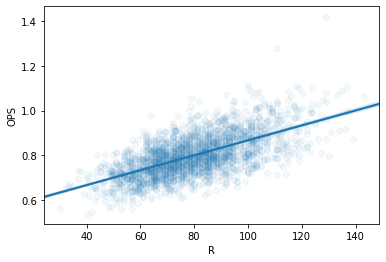

In [44]:
sns.regplot(x='R', y='OPS', data=statsEra, scatter_kws={'alpha':0.05})
plt.show()

***These plots provide the best visual demonstrations of differences in the three eras. There is much greater variance in the era of a lowered mound from the worst qualified batter to the best qualified batter and the number of runs they scored.***

***Notice how the cluster flattens, elongates in the steroid and stats eras. It is obvious something changed in these eras that tighetned the spectrum of the mean production.***

Text(0.5, 0.98, 'x=Runs | y=OPS')

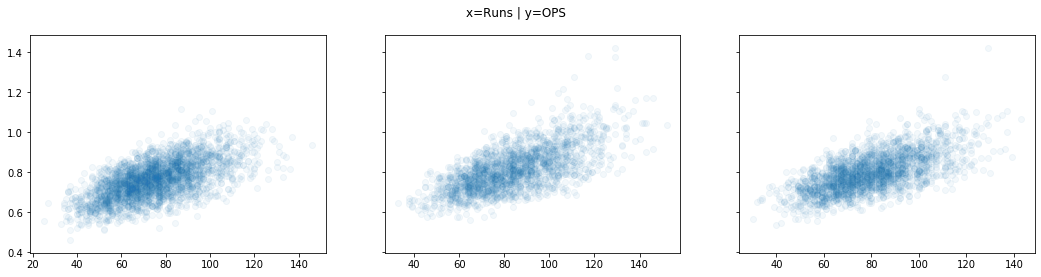

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
axs[0].scatter(lowerMound['R'], lowerMound['OPS'], alpha=.05)
axs[1].scatter(steroidEra['R'], steroidEra['OPS'], alpha=.05)
axs[2].scatter(statsEra['R'], statsEra['OPS'], alpha=.05)
fig.suptitle('x=Runs | y=OPS')

***These next data sets are created to test the progression of the game. As part of my hypothesis, increased player skill levels due to amount of time playing the game and the progression of the game itself (the longer it is played, the better everyone gets, which ultimately cancels one another out) results in better play on it's own as players reach theoretical max levels of production. If stats driven development is truly at play, this is where it ought to show up most visibly: data sets taken from the last five years of each data set.***

***Additionally, the loweredMound era has a significant change that ocurred: free agency. This alloweed players to change teams, bid out thir services, and make enough money to begin focusing on baseball full-time rather than having normal jobs in the offseason. This happened in the 70s and changed the face of the game.***

In [46]:
lmLastFive = batdata[(batdata['yearID'] >= 1987) & (batdata['yearID'] <= 1991) & (batdata['PA'] >= 502)]
lmLastFive.describe()

yearID       stint           G          AB           R           H          2B          3B          HR         RBI          SB          CS          BB          SO        IBB         HBP          SH          SF        GIDP          PA      OnBase         OBP      single      double      triple       homer          TB        SLUG         OPS          BA
count   614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.00000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000
mean   1988.960912    1.006515  147.086319  539.890879   75.947883  148.697068   26.711726    3.713355   16.029316   71.828990   14.986971    6.187296   56.301303   82.315961    6.35342    3.271987    3.083062    5.114007   11.597720  604.578176  208.270358    0.343482  102.242671   53.423453   11.140065   64.117264  230.923453    0.426777    0.770259    0.274611
std       1.426309    0.080516    9.985342   55.768715   17.809410   24.162165    7.506167    2.965146   10.330072   22.220056   15.504243    4.993872   22.047304   31.557883    5.56268    2.632331    4.399459    2.680368    4.957509   60.061276   34.256758    0.036222   21.264007   15.012333    8.895437   41.320290   45.874135    0.066801    0.092110    0.027401
min    1987.000000    1.000000  115.000000  418.000000   36.000000   80.000000    8.000000    0.000000    0.000000   18.000000    0.000000    0.000000   11.000000   19.000000    0.00000    0.000000    0.000000    0.000000    0.000000  502.000000  130.000000    0.228000   39.000000   16.000000    0.000000    0.000000  126.000000    0.258000    0.518000    0.178571
25%    1988.000000    1.000000  141.000000  493.000000   63.000000  131.000000   22.000000    1.250000    7.000000   55.000000    4.000000    3.000000   39.000000   60.000000    2.00000    1.000000    0.000000    3.000000    8.000000  554.250000  181.250000    0.316250   88.000000   44.000000    3.750000   28.000000  197.000000    0.378250    0.703000    0.255437
50%    1989.000000    1.000000  149.000000  544.000000   75.000000  148.000000   26.000000    3.000000   15.000000   69.500000    9.000000    5.000000   53.000000   79.000000    5.00000    3.000000    1.000000    5.000000   11.000000  608.500000  206.000000    0.342000  100.500000   52.000000    9.000000   60.000000  226.500000    0.422000    0.765500    0.273562
75%    1990.000000    1.000000  155.000000  585.000000   87.000000  164.000000   32.000000    5.000000   23.750000   88.000000   22.000000    9.000000   71.000000  103.000000    9.00000    5.000000    4.000000    7.000000   15.000000  653.000000  232.750000    0.368000  116.000000   64.000000   15.000000   95.000000  261.000000    0.470750    0.830750    0.293039
max    1991.000000    2.000000  163.000000  665.000000  133.000000  234.000000   51.000000   17.000000   51.000000  137.000000  109.000000   29.000000  138.000000  186.000000   32.00000   17.000000   39.000000   15.000000   27.000000  749.000000  342.000000    0.476000  171.000000  102.000000   51.000000  204.000000  369.000000    0.635000    1.056000    0.370119

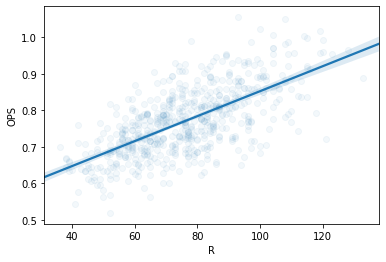

In [47]:
sns.regplot(x='R', y='OPS', data=lmLastFive, scatter_kws={'alpha':0.05})
plt.show()

In [48]:
sdLastFive = steroidEra = batdata[(batdata['yearID'] >= 1999) & (batdata['yearID'] <= 2003) & (batdata['PA'] >= 502)]
sdLastFive.describe()

yearID       stint           G          AB           R           H          2B          3B          HR         RBI          SB          CS          BB          SO         IBB         HBP          SH          SF        GIDP          PA      OnBase         OBP      single      double      triple       homer          TB        SLUG         OPS          BA
count   729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000  729.000000
mean   2000.968450    1.001372  146.855967  543.969822   86.252401  154.953361   31.005487    3.244170   21.466392   82.687243   11.555556    4.727023   60.541838   92.492455    5.403292    5.932785    2.429355    5.126200   12.491084  615.570645  221.427984    0.358412   99.237311   62.010974    9.732510   85.865569  256.846365    0.471373    0.829785    0.284230
std       1.424026    0.037037   10.860117   57.761699   20.033336   24.630746    8.016979    2.751757   11.997449   26.753882   11.980410    3.889384   25.516343   30.054031    6.207209    4.528558    3.603000    2.671684    4.864396   64.299144   38.760225    0.040067   20.260662   16.033957    8.255271   47.989794   53.687317    0.081841    0.114770    0.027864
min    1999.000000    1.000000  112.000000  390.000000   39.000000  103.000000   11.000000    0.000000    0.000000   17.000000    0.000000    0.000000   12.000000   26.000000    0.000000    0.000000    0.000000    0.000000    1.000000  502.000000  142.000000    0.260000   49.000000   22.000000    0.000000    0.000000  131.000000    0.291000    0.563000    0.208812
25%    2000.000000    1.000000  140.000000  493.000000   71.000000  136.000000   25.000000    1.000000   12.000000   62.000000    3.000000    2.000000   42.000000   71.000000    2.000000    3.000000    0.000000    3.000000    9.000000  561.000000  192.000000    0.331000   86.000000   50.000000    3.000000   48.000000  217.000000    0.411000    0.747000    0.264463
50%    2001.000000    1.000000  149.000000  543.000000   84.000000  152.000000   31.000000    2.000000   20.000000   81.000000    7.000000    4.000000   56.000000   89.000000    4.000000    5.000000    1.000000    5.000000   12.000000  622.000000  218.000000    0.354000   97.000000   62.000000    6.000000   80.000000  251.000000    0.461000    0.815000    0.281034
75%    2002.000000    1.000000  156.000000  588.000000  101.000000  172.000000   36.000000    5.000000   29.000000  103.000000   17.000000    7.000000   75.000000  112.000000    7.000000    8.000000    4.000000    7.000000   16.000000  672.000000  249.000000    0.384000  111.000000   72.000000   15.000000  116.000000  294.000000    0.527000    0.901000    0.303030
max    2003.000000    2.000000  163.000000  696.000000  152.000000  242.000000   59.000000   20.000000   73.000000  165.000000   72.000000   22.000000  198.000000  188.000000   68.000000   28.000000   17.000000   16.000000   32.000000  745.000000  356.000000    0.582000  192.000000  118.000000   60.000000  292.000000  425.000000    0.863000    1.381000    0.378995

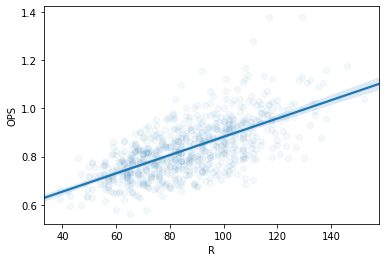

In [49]:
sns.regplot(x='R', y='OPS', data=sdLastFive, scatter_kws={'alpha':0.05})
plt.show()

In [50]:
stLastFive = statsEra = batdata[(batdata['yearID'] >= 2014) & (batdata['PA'] >= 502)]
stLastFive.describe()

yearID  stint           G          AB           R           H          2B          3B          HR         RBI          SB          CS          BB          SO         IBB         HBP          SH          SF        GIDP          PA      OnBase         OBP      single      double      triple       homer          TB        SLUG         OPS          BA
count   674.000000  674.0  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000  674.000000
mean   2015.992582    1.0  146.660237  543.664688   76.593472  147.502967   29.317507    2.980712   20.044510   73.396142    9.562315    3.473294   52.974777  113.629080    4.140950    5.643917    1.172107    4.376855   12.385757  606.660237  206.121662    0.338628   95.160237   58.635015    8.942136   80.178042  242.915430    0.445840    0.784467    0.270563
std       1.410512    0.0   10.468746   53.553187   17.491862   23.400400    7.483717    2.566428   10.111464   20.547818   10.366958    3.243010   21.496763   33.081988    4.334047    4.034130    2.062196    2.347987    5.402342   60.218586   33.708876    0.033810   20.846453   14.967434    7.699283   40.445855   44.915277    0.063222    0.088867    0.027124
min    2014.000000    1.0  114.000000  402.000000   32.000000   79.000000    9.000000    0.000000    1.000000   26.000000    0.000000    0.000000    9.000000   38.000000    0.000000    0.000000    0.000000    0.000000    0.000000  502.000000  127.000000    0.243000   32.000000   18.000000    0.000000    4.000000  139.000000    0.296000    0.539000    0.168085
25%    2015.000000    1.0  140.000000  501.000000   65.000000  130.000000   24.000000    1.000000   13.000000   58.000000    2.000000    1.000000   37.000000   90.000000    1.000000    3.000000    0.000000    3.000000    8.000000  553.250000  181.000000    0.315000   80.000000   48.000000    3.000000   52.000000  210.000000    0.401000    0.723000    0.251909
50%    2016.000000    1.0  148.500000  547.000000   75.000000  147.000000   29.000000    2.000000   19.500000   73.000000    6.000000    3.000000   50.000000  111.500000    3.000000    5.000000    0.000000    4.000000   12.000000  609.000000  202.500000    0.336000   94.000000   58.000000    6.000000   78.000000  240.000000    0.440500    0.778500    0.270499
75%    2017.000000    1.0  155.000000  586.000000   88.000000  164.000000   34.000000    5.000000   26.000000   87.000000   14.000000    5.000000   66.000000  135.000000    6.000000    8.000000    2.000000    6.000000   16.000000  655.000000  229.000000    0.360000  108.000000   68.000000   15.000000  104.000000  271.000000    0.486000    0.836750    0.288349
max    2018.000000    1.0  162.000000  684.000000  137.000000  225.000000   56.000000   14.000000   59.000000  133.000000   64.000000   23.000000  143.000000  219.000000   29.000000   30.000000   13.000000   15.000000   31.000000  744.000000  321.000000    0.460000  170.000000  112.000000   42.000000  236.000000  387.000000    0.649000    1.109000    0.347826

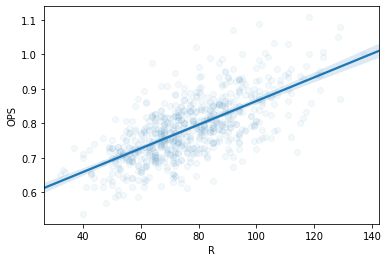

In [51]:
sns.regplot(x='R', y='OPS', data=stLastFive, scatter_kws={'alpha':0.05})
plt.show()

***Through these we see that the steroid era is still outperforming everyone.***

***The lmLastFive and stLastFive, however, look very similar. Let's See them all together, and then look at some overlays to see how they look in the same space.***

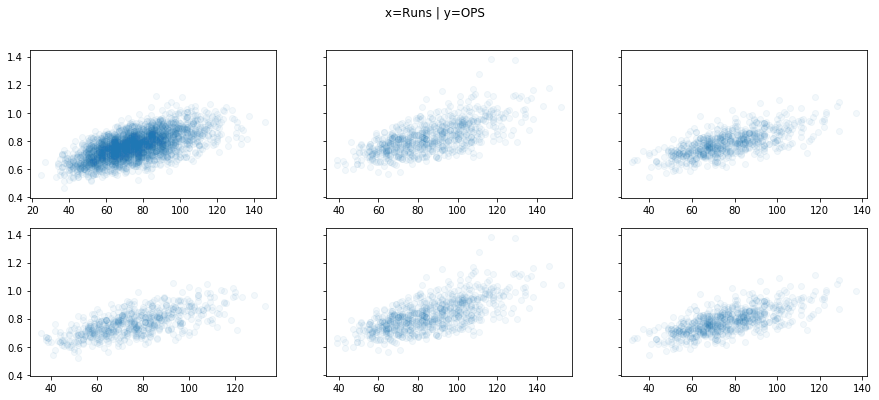

In [64]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharey=True)
axs[0, 0].scatter(lowerMound['R'], lowerMound['OPS'], alpha=.05)
axs[0, 1].scatter(steroidEra['R'], steroidEra['OPS'], alpha=.05)
axs[0, 2].scatter(statsEra['R'], statsEra['OPS'], alpha=.05)
axs[1, 0].scatter(lmLastFive['R'], lmLastFive['OPS'], alpha=.05)
axs[1, 1].scatter(sdLastFive['R'], sdLastFive['OPS'], alpha=.05)
axs[1, 2].scatter(stLastFive['R'], stLastFive['OPS'], alpha=.05)
fig.suptitle('x=Runs | y=OPS');

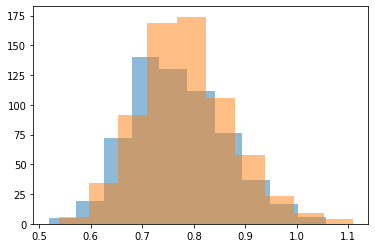

In [53]:
plt.hist(lmLastFive['OPS'], alpha=.5)
plt.hist(stLastFive['OPS'], alpha=.5)
plt.show()

***And now the R production.***

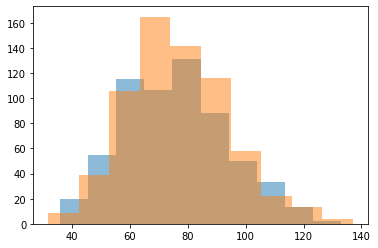

In [54]:
plt.hist(lmLastFive['R'], alpha=.5)
plt.hist(stLastFive['R'], alpha=.5)
plt.show()

***Again, they look very similar.***

***Let's look at some sample means for the two eras to make sure our data is normally distributed.***

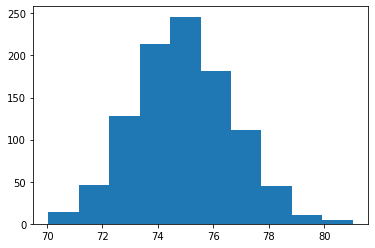

In [55]:
lmMeans = [lowerMound['R'].sample(n = 100).mean() for _ in range(1000)]
plt.hist(lmMeans);

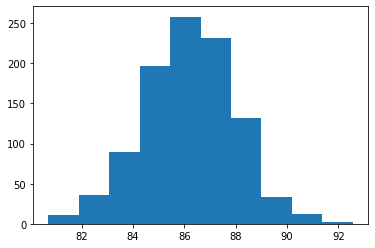

In [56]:
sdMeans = [steroidEra['R'].sample(n = 100).mean() for _ in range(1000)]
plt.hist(sdMeans);

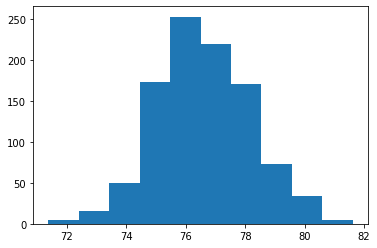

In [57]:
stMeans = [statsEra['R'].sample(n = 100).mean() for _ in range(1000)]
plt.hist(stMeans);

***The means of R are all normally distributed.***

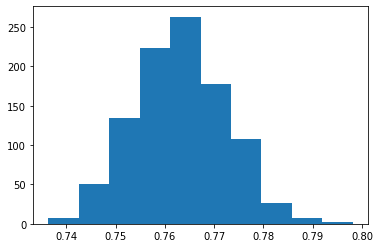

In [58]:
lmMeans = [lowerMound['OPS'].sample(n = 100).mean() for _ in range(1000)]
plt.hist(lmMeans);

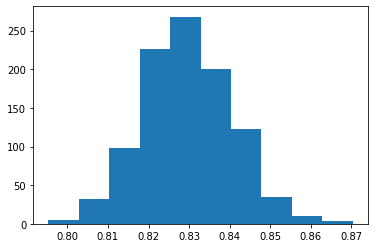

In [59]:
sdMeans = [steroidEra['OPS'].sample(n = 100).mean() for _ in range(1000)]
plt.hist(sdMeans);

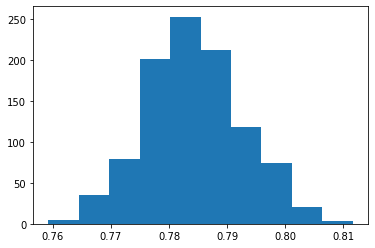

In [60]:
stMeans = [statsEra['OPS'].sample(n = 100).mean() for _ in range(1000)]
plt.hist(stMeans);

***Since the means are all distributed normally, let's run a series of Ttests and see where there is significant difference and where there is not.***

***Ttest of eras lowerMound and stats, given the presumption of a lack of PED usage.***

In [61]:
print(stats.ttest_ind(lowerMound['OPS'], statsEra['OPS'])) #null = reject pvalue=9.264435572999819e-08
print(stats.ttest_ind(lowerMound['R'], statsEra['R'])) #null = reject pvalue=0.028278847088743862
print(stats.ttest_ind(lowerMound['OBP'], statsEra['OBP'])) #null = rejct pvalue=0.005822886802050661
print(stats.ttest_ind(lowerMound['SLUG'], statsEra['SLUG'])) #null = reject pvalue=3.059099661607167e-18
print(stats.ttest_ind(lowerMound['BA'], statsEra['BA'])) #null = reject pvalue=0.00029315404042579276
print(stats.ttest_ind(lowerMound['PA'], statsEra['PA'])) #null = accept
print(stats.ttest_ind(lowerMound['AB'], statsEra['AB'])) #null = accept

Ttest_indResult(statistic=-5.352096706516884, pvalue=9.264435572999819e-08)
Ttest_indResult(statistic=-2.1943250154243454, pvalue=0.028278847088743862)
Ttest_indResult(statistic=2.759321148067626, pvalue=0.005822886802050661)
Ttest_indResult(statistic=-8.758230406552341, pvalue=3.059099661607167e-18)
Ttest_indResult(statistic=3.6250020193435937, pvalue=0.00029315404042579276)
Ttest_indResult(statistic=-0.4307034370593669, pvalue=0.6667110660596509)
Ttest_indResult(statistic=-0.6934771259789159, pvalue=0.48805710481748343)


***Our AB and PA show no signs of significance, but everything else suggests there is significance between the two eras. Now we will look at the last five years of each era and see if anything changes.***

In [62]:
print(stats.ttest_ind(lmLastFive['OPS'], stLastFive['OPS'])) #null = reject pvalue=0.004930227014237343
print(stats.ttest_ind(lmLastFive['R'], stLastFive['R'])) #null = accept
print(stats.ttest_ind(lmLastFive['OBP'], stLastFive['OBP'])) #null = reject pvalue=0.012989154868119981
print(stats.ttest_ind(lmLastFive['SLUG'], stLastFive['SLUG'])) #null = reject pvalue=1.6788897883125095e-07
print(stats.ttest_ind(lmLastFive['BA'], stLastFive['BA'])) #null = reject pvalue=0.007870697821893905
print(stats.ttest_ind(lmLastFive['PA'], stLastFive['PA'])) #null = accept
print(stats.ttest_ind(lmLastFive['AB'], stLastFive['AB'])) #null = accept

Ttest_indResult(statistic=-2.8164325144059137, pvalue=0.004930227014237343)
Ttest_indResult(statistic=-0.6558684942228415, pvalue=0.5120260610536571)
Ttest_indResult(statistic=2.4875337925894367, pvalue=0.012989154868119981)
Ttest_indResult(statistic=-5.260770227744551, pvalue=1.6788897883125095e-07)
Ttest_indResult(statistic=2.661738424456634, pvalue=0.007870697821893905)
Ttest_indResult(statistic=-0.6205259636066971, pvalue=0.5350215153592877)
Ttest_indResult(statistic=-1.2384561204859503, pvalue=0.21577300021623674)


***And that is very interesting. Everything fell along the same lines, though with reduced distance, until R, which flipped from rejecting the null to accepting it. When comparing the last five years of players in lowerMound, 1987-1991, to the last five years of players in the stats generation, 2014-18, R did not show significance.***

***Conclusion from this test:***

***Since AB and PA cannot reject Ho, and OPS, OBP, SLUG, and BA can reject Ho, the fact that R cannot reject Ho between the latest and most recent statsitics from the two non-steroidal eras is significant in possibly showing that OPS is not a primary determining factor in the increase of R asit is currently considered. Since the stats era is consistent with R to the previous non-steroid era, it can be hypothesized that R production did not change with the increase of OPS, OBP, SLUG, and BA.***

***The next steps would be correcting for the impact of steroids, and then determining what has impacted R? Major League Baseball has set records the last three years in R and HR. Why does R not show significance between the two eras? Is it pitching? Could it be fewer hits due to changing defense? Fewer singles because angled swings create less solid contact? This will help us determine if signing the guy who wants 35mil per season makes more or less sense the guy we can get for 15mil because his R production is more consistent.***